In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

test_path = "./data/Test"
train_path = "./data/Train"
validation_path = "./data/Validation"
batch_size = 32
img_height = 128
img_width = 128
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1322 files belonging to 3 classes.


2023-02-19 21:11:57.317065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 21:12:01.860861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5374 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  validation_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 60 files belonging to 3 classes.


In [5]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 3 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Powdery', 'Rust']


(32, 128, 128, 3)
(32,)


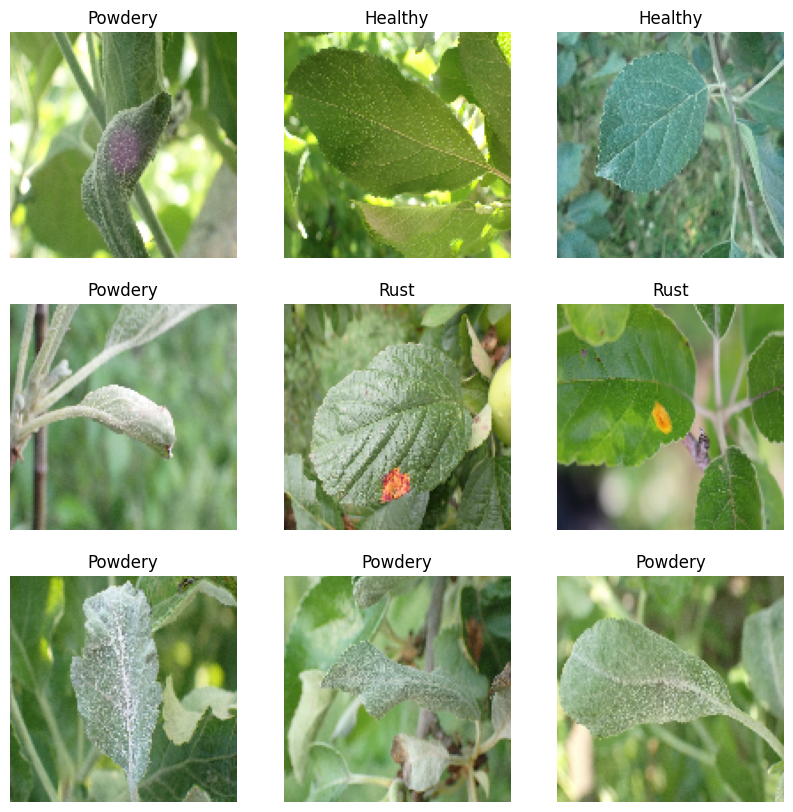

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [8]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
"""with tf.device('/device:GPU:0'):"""
normalization_layer = layers.Rescaling(1./255)

"""with tf.device('/device:GPU:0'):"""
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.05370711 0.9950981


In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

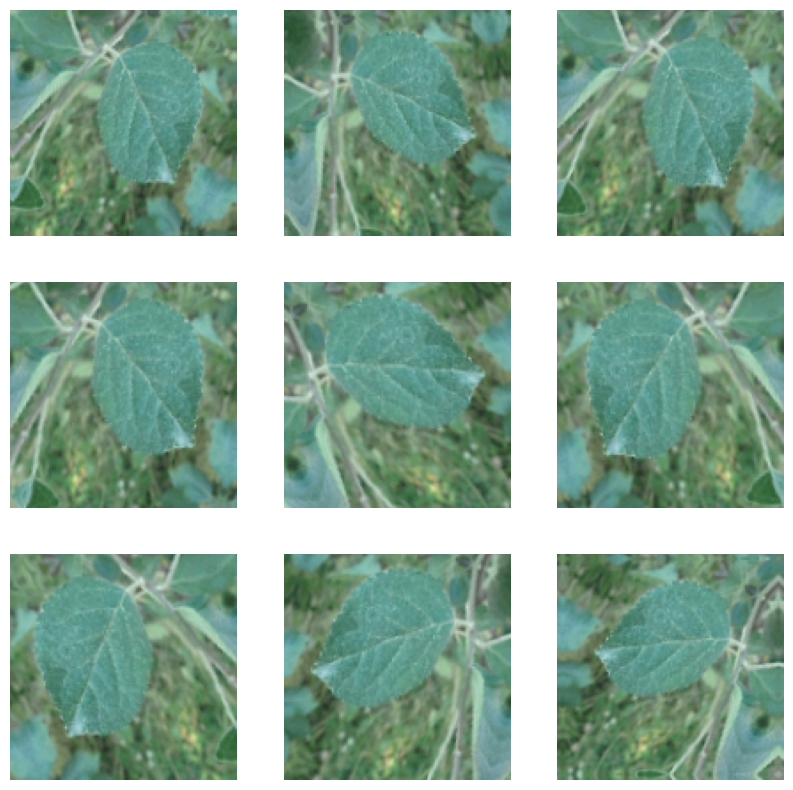

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
num_classes = len(class_names
                  )
def create_model():

  model = Sequential([
    data_augmentation,
    #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(250, activation='relu'),
    layers.Dense(num_classes)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [13]:
model = create_model()

In [14]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
if (latest):
  print(latest)
  model.load_weights(latest)

In [15]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=20*batch_size)

In [16]:
epochs=10

In [17]:
with tf.device('/device:GPU:0'):

  history = model.fit(
    normalized_ds,
    #train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp_callback]
  )

Epoch 1/10


2023-02-19 21:12:55.951245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


42/42 [==============================] - 53s 656ms/step - loss: 1.1201 - accuracy: 0.4834 - val_loss: 112.0613 - val_accuracy: 0.6000
Epoch 2/10
42/42 [==============================] - 20s 395ms/step - loss: 0.6907 - accuracy: 0.6657 - val_loss: 101.1992 - val_accuracy: 0.6167
Epoch 3/10
42/42 [==============================] - 17s 335ms/step - loss: 0.5947 - accuracy: 0.7352 - val_loss: 127.3319 - val_accuracy: 0.6667
Epoch 4/10
42/42 [==============================] - 19s 366ms/step - loss: 0.5385 - accuracy: 0.7753 - val_loss: 129.7047 - val_accuracy: 0.7333
Epoch 5/10
42/42 [==============================] - 19s 368ms/step - loss: 0.4876 - accuracy: 0.8011 - val_loss: 61.4976 - val_accuracy: 0.7333
Epoch 6/10
42/42 [==============================] - 19s 361ms/step - loss: 0.3687 - accuracy: 0.8533 - val_loss: 187.5266 - val_accuracy: 0.6667
Epoch 7/10
42/42 [==============================] - 20s 386ms/step - loss: 0.3015 - accuracy: 0.8812 - val_loss: 167.6027 - val_accuracy: 0.73

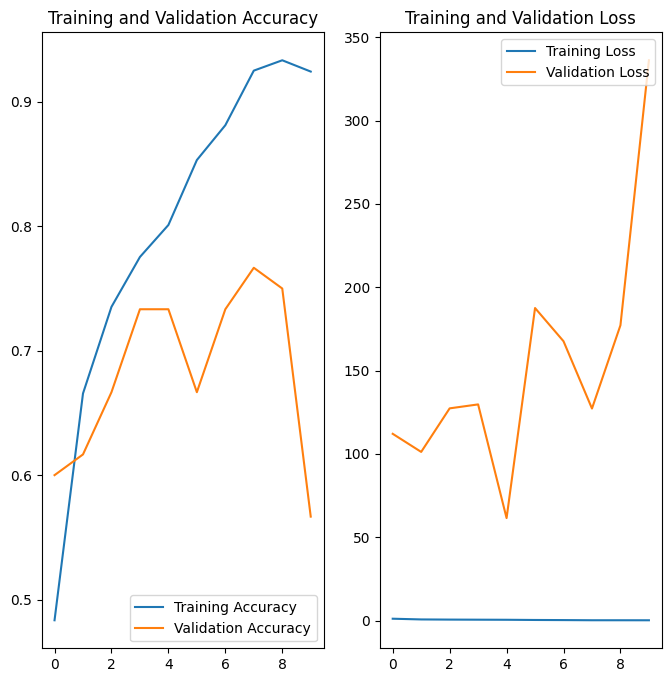

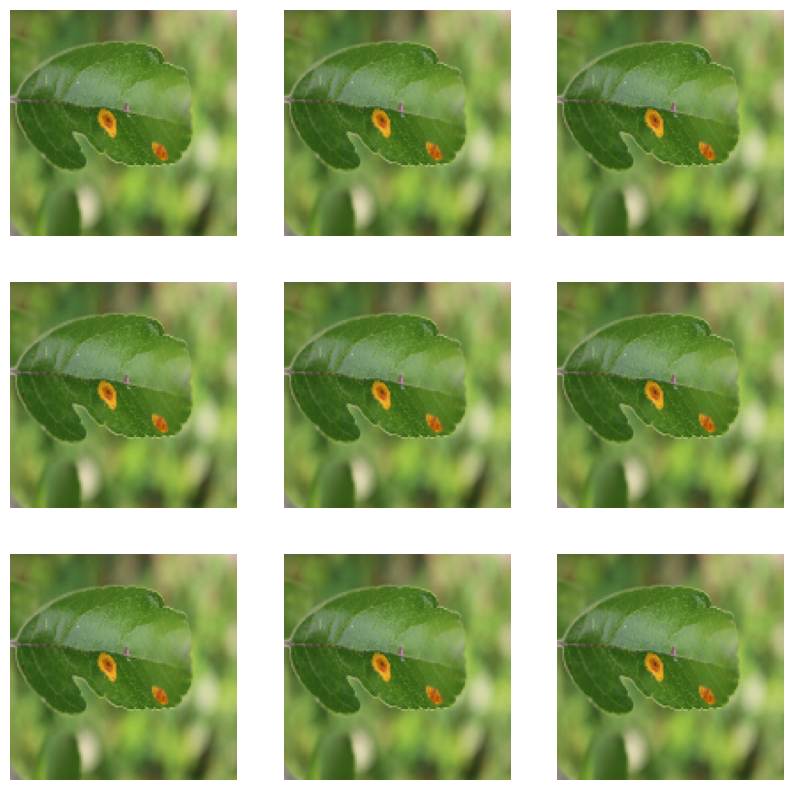

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [19]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

model.save('saved_model/plants_classifier')

1/1 [==============================] - 0s 472ms/step
This image most likely belongs to Rust with a 100.00 percent confidence.


INFO:tensorflow:Assets written to: saved_model/plants_classifier/assets


INFO:tensorflow:Assets written to: saved_model/plants_classifier/assets
